In [1]:
from collections import namedtuple
from functools import partial

import numpy as np

from scipy.stats import mode

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from sklearn.neighbors import NearestNeighbors

from imblearn.combine import SPIDER

In [2]:
X = np.array([
    [-11.83, -6.81],
    [-11.72, -2.34],
    [-11.43, -5.85],
    [-10.66, -4.33],
    [-9.64, -7.05],
    [-8.39, -4.41],
    [-8.07, -5.66],
    [-7.28, 0.91],
    [-7.24, -2.41],
    [-6.13, -4.81],
    [-5.92, -6.81],
    [-4., -1.81],
    [-3.96, 2.67],
    [-3.74, -7.31],
    [-2.96, 4.69],
    [-1.56, -2.33],
    [-1.02, -4.57],
    [0.46, 4.07],
    [1.2, -1.53],
    [1.32, 0.41],
    [1.56, -5.19],
    [2.52, 5.89],
    [3.03, -4.15],
    [4., -0.59],
    [4.4, 2.07],
    [4.41, -7.45],
    [4.45, -4.12],
    [5.13, -6.28],
    [5.4, -5],
    [6.26, 4.65],
    [7.02, -6.22],
    [7.5, -0.11],
    [8.1, -2.05],
    [8.42, 2.47],
    [9.62, 3.87],
    [10.54, -4.47],
    [11.42, 0.01]
])

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
    0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0])

In [3]:
Neighborhood = namedtuple('Neighborhood', 'radius, neighbors')


def plot_X(X, ax, **kwargs):
    ax.scatter(X[:, 0], X[:, 1], **kwargs)


def correct(nn, y_fit, X, y, additional=False):
    n_neighbors = nn.n_neighbors
    if additional:
        n_neighbors += 2
    nn_idxs = nn.kneighbors(X, n_neighbors, return_distance=False)[:, 1:]
    y_pred, _ = mode(y_fit[nn_idxs], axis=1)
    return (y == y_pred.ravel())


def get_neighborhoods(spider, X_fit, y_fit, X_flagged, y_flagged, idx):
    point = X_flagged[idx]

    additional = (spider.kind == 'strong')
    if correct(spider.nn_, y_fit, point[np.newaxis], y_flagged[idx][np.newaxis], additional=additional):
        additional = False

    idxs_k = spider._locate_neighbors(point[np.newaxis])
    neighbors_k = X_fit[idxs_k].squeeze()
    farthest_k = neighbors_k[-1]
    radius_k = np.linalg.norm(point - farthest_k)
    neighborhood_k = Neighborhood(radius_k, neighbors_k)

    idxs_k2 = spider._locate_neighbors(point[np.newaxis], additional=True)
    neighbors_k2 = X_fit[idxs_k2].squeeze()
    farthest_k2 = neighbors_k2[-1]
    radius_k2 = np.linalg.norm(point - farthest_k2)
    neighborhood_k2 = Neighborhood(radius_k2, neighbors_k2)

    return neighborhood_k, neighborhood_k2, point, additional


def draw_neighborhoods(spider, neighborhood_k, neighborhood_k2, point, additional, ax, outer=True, alpha=0.5):
    PartialCircle = partial(Circle, facecolor='none', edgecolor='black', alpha=alpha)

    circle_k = PartialCircle(point, neighborhood_k.radius, linestyle='-')

    linestyle = ('-' if additional else '--')
    circle_k2 = PartialCircle(point, neighborhood_k2.radius, linestyle=linestyle)

    if additional:
        neighbors = neighborhood_k2.neighbors
    else:
        neighbors = neighborhood_k.neighbors
        ax.add_patch(circle_k)

    if (spider.kind == 'strong') and outer:
        ax.add_patch(circle_k2)


def draw_amplification(X_flagged, point, neighbors, ax):
    for idx, neigh in enumerate(neighbors):
        arr = np.vstack([point, neigh])
        xs, ys = np.split(arr, 2, axis=1)
        linestyle = 'solid' if neigh in X_flagged else 'dotted'
        ax.plot(xs, ys, color='black', linestyle=linestyle)

In [4]:
def plot_spider(kind, X, y):
    if kind == 'strong':
        _, axes = plt.subplots(2, 1, figsize=(12, 16))
    else:
        _, axes = plt.subplots(1, 1, figsize=(12, 8))
        axes = np.atleast_1d(axes)


    spider = SPIDER(kind=kind)
    spider.fit_resample(X, y)


    # is_safe = spider._knn_correct(X, y)
    is_safe = correct(spider.nn_, y, X, y)
    is_minor = (y == 1)

    X_major = X[~is_minor]
    X_minor = X[is_minor]

    X_noise = X[~is_safe]
    X_safe = X[is_safe]


    # Class-Noise
    X_major_noise = X[~is_minor & ~is_safe]
    y_major_noise = y[~is_minor & ~is_safe]

    X_minor_noise = X[is_minor & ~is_safe]
    y_minor_noise = y[is_minor & ~is_safe]


    # Class-Safe
    X_major_safe = X[~is_minor & is_safe]
    y_major_safe = y[~is_minor & is_safe]

    X_minor_safe = X[is_minor & is_safe]
    y_minor_safe = y[is_minor & is_safe]


    partial_neighborhoods = partial(get_neighborhoods, spider, X, y)
    partial_amplification = partial(draw_amplification, X_major_safe)
    partial_draw_neighborhoods = partial(draw_neighborhoods, spider)

    size = 500
    for axis in axes:
        #: Majority and Minority Samples
        plot_X(X_minor, ax=axis, label='Minority class', s=size, marker='_')
        plot_X(X_major, ax=axis, label='Minority class', s=size, marker='+')

        #: Overlay ring around noisy samples for both classes
        plot_X(X_noise, ax=axis, label='Noisy Sample', s=size, marker='o', facecolors='none', edgecolors='black')


    #: Neighborhoods for Noisy Minority Samples
    for idx in range(len(X_minor_noise)):
        neighborhoods = partial_neighborhoods(X_minor_noise, y_minor_noise, idx=idx)
        partial_draw_neighborhoods(*neighborhoods, ax=axes[0], outer=(spider.kind == 'strong'))
        neighborhood_k, neighborhood_k2, point, additional = neighborhoods
        neighbors = neighborhood_k2.neighbors if additional else neighborhood_k.neighbors
        partial_amplification(point, neighbors, ax=axes[0])


    axes[0].axis('equal')
    axes[0].legend(markerscale=0.5)
    axes[0].set_title(f'SPIDER-{spider.kind.title()}')


    #: Neighborhoods for Safe Minority Samples (kind='strong' only)
    if spider.kind == 'strong':
        for idx in range(len(X_minor_safe)):
            neighborhoods = partial_neighborhoods(X_minor_safe, y_minor_safe, idx=idx)

            neighborhood_k, _, point, additional = neighborhoods
            neighbors = neighborhood_k.neighbors
            draw_flag = np.any(np.isin(neighbors, X_major_safe))

            alpha = 0.5 if draw_flag else 0.1
            partial_draw_neighborhoods(*neighborhoods[:-1], additional=False, ax=axes[1], outer=False, alpha=alpha)

            if draw_flag:
                partial_amplification(point, neighbors, ax=axes[1])

            axes[1].axis('equal')
            axes[1].legend(markerscale=0.5)
            axes[1].set_title(f'SPIDER-{spider.kind.title()}')

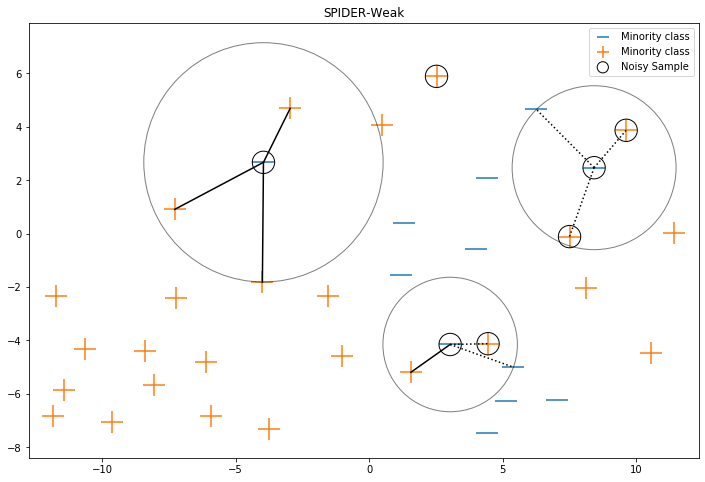

In [5]:
plot_spider('weak', X, y)

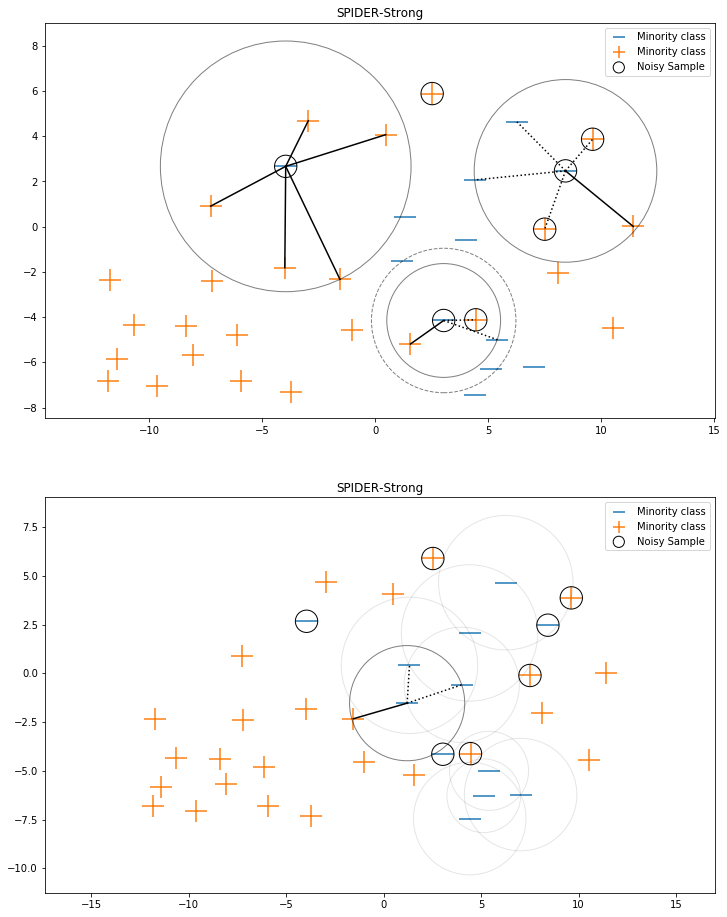

In [6]:
plot_spider('strong', X, y)